In [2]:
# %% [code]
# ============================================================================
# COMPLETE CANADA DATA LOADER FOR NOTEBOOKS
# ============================================================================

import pandas as pd
import numpy as np
import os
from datetime import datetime

print("="*70)
print("CANADA ECONOMIC DATA LOADER")
print("="*70)

# Set data directory
DATA_DIR = "../data/raw"
print(f"Looking for data in: {DATA_DIR}")

# Check if data directory exists
if not os.path.exists(DATA_DIR):
    print(f"✗ Directory '{DATA_DIR}' not found!")
    print(f"Current working directory: {os.getcwd()}")
    print("\nPlease ensure you're running from project root.")
    print("Expected structure: Calgary-Economic-Research/data/raw/")
else:
    print(f"✓ Data directory exists")
    
    # List files in data directory
    print(f"\nFiles in {DATA_DIR}:")
    files = os.listdir(DATA_DIR)
    for file in files:
        print(f"  - {file}")

# %% [code]
# 1. LOAD OIL DATA
print("\n" + "="*70)
print("1. LOADING OIL PRICE DATA")
print("="*70)

oil_path = os.path.join(DATA_DIR, "wti_crude_prices_2010_2024.csv")
if os.path.exists(oil_path):
    try:
        oil_data = pd.read_csv(oil_path)
        oil_data['date'] = pd.to_datetime(oil_data['date'])
        print(f"✓ Oil data loaded: {len(oil_data)} rows")
        print(f"  Date range: {oil_data['date'].min().date()} to {oil_data['date'].max().date()}")
        print(f"  Price range: ${oil_data['price'].min():.2f} to ${oil_data['price'].max():.2f}")
    except Exception as e:
        print(f"✗ Error loading oil data: {e}")
        oil_data = None
else:
    print(f"✗ Oil data file not found: {oil_path}")
    print("  Run notebooks/01_oil_price_analysis.ipynb first to generate this file")
    oil_data = None

# %% [code]
# 2. LOAD CANADA GDP DATA (FIXED - HANDLES NaN)
print("\n" + "="*70)
print("2. LOADING CANADA GDP DATA")
print("="*70)

gdp_path = os.path.join(DATA_DIR, "canada_gdp.csv")
if os.path.exists(gdp_path):
    try:
        # Read with skiprows - data starts at line 12
        gdp_raw = pd.read_csv(gdp_path, encoding='utf-8', skiprows=11)
        
        print(f"✓ Canada GDP loaded: {len(gdp_raw)} rows, {len(gdp_raw.columns)} columns")
        print(f"  Columns: {gdp_raw.columns.tolist()}")
        
        # The first column has industry names, but first row might be NaN
        industry_name_col = gdp_raw.columns[0]
        
        # Find the "All industries" row (skip NaN rows)
        all_industries_row = None
        for idx, row in gdp_raw.iterrows():
            industry_name = str(row[industry_name_col]) if not pd.isna(row[industry_name_col]) else ""
            if "All industries" in industry_name:
                all_industries_row = row
                break
        
        if all_industries_row is not None:
            print(f"✓ Found 'All industries' row at index {idx}")
            
            # Extract time series data (skip first column which is industry name)
            time_series_data = all_industries_row.iloc[1:]
            
            # Convert to long format
            gdp_series = []
            for col_name, value in time_series_data.items():
                if pd.isna(value):
                    continue
                    
                # Clean the value
                try:
                    clean_value = float(str(value).replace(',', ''))
                except:
                    continue
                
                # Parse date from column name (e.g., "Q1 2010")
                col_str = str(col_name)
                
                # Try to parse quarter
                try:
                    if col_str.startswith('Q'):
                        # Format: "Q1 2010" or '"Q1 2010"'
                        if col_str.startswith('"') and col_str.endswith('"'):
                            col_str = col_str[1:-1]
                        
                        quarter, year = col_str.split()
                        quarter_num = int(quarter[1])
                        month = (quarter_num - 1) * 3 + 1  # Q1=Jan(1), Q2=Apr(4), Q3=Jul(7), Q4=Oct(10)
                        date = pd.to_datetime(f"{year}-{month:02d}-01")
                        
                        gdp_series.append({'date': date, 'gdp': clean_value})
                except Exception as e:
                    print(f"  Warning: Could not parse date '{col_str}': {e}")
                    continue
            
            gdp_data = pd.DataFrame(gdp_series)
            gdp_data = gdp_data.sort_values('date').reset_index(drop=True)
            
            print(f"✓ Processed GDP data: {len(gdp_data)} quarters")
            print(f"  Date range: {gdp_data['date'].min().date()} to {gdp_data['date'].max().date()}")
            print(f"  GDP range: ${gdp_data['gdp'].min():,.0f} to ${gdp_data['gdp'].max():,.0f}")
            print(f"\nSample of GDP data:")
            print(gdp_data.head())
            
        else:
            print(f"✗ Could not find 'All industries' row")
            print(f"  Available rows:")
            for idx, row in gdp_raw.iterrows():
                industry = row[industry_name_col]
                if not pd.isna(industry):
                    print(f"    Row {idx}: {industry}")
            gdp_data = None
            
    except Exception as e:
        print(f"✗ Error loading GDP data: {e}")
        import traceback
        traceback.print_exc()
        gdp_data = None
else:
    print(f"✗ Canada GDP file not found")
    gdp_data = None

# 3. LOAD CANADA EMPLOYMENT DATA (WIDE FORMAT FIX)
print("\n" + "="*70)
print("3. LOADING CANADA EMPLOYMENT DATA (WIDE FORMAT)")
print("="*70)

emp_path = os.path.join(DATA_DIR, "canada_employment.csv")
if os.path.exists(emp_path):
    try:
        # The employment data starts at line 11 (0-indexed 10)
        emp_raw = pd.read_csv(emp_path, encoding='utf-8', skiprows=10, nrows=2)  # Read first few industry rows
        
        print(f"✓ Canada employment loaded: {len(emp_raw)} industry rows, {len(emp_raw.columns)} months")
        print(f"  First few columns: {emp_raw.columns.tolist()[:5]}")
        
        # Find the industry name column
        industry_name_col = emp_raw.columns[0]
        print(f"  Industry column: '{industry_name_col}'")
        print(f"  Industries: {emp_raw[industry_name_col].tolist()}")
        
        # Find the "Industrial aggregate including unclassified businesses" row
        target_rows = emp_raw[emp_raw[industry_name_col].str.contains("Industrial aggregate", na=False)]
        
        if len(target_rows) > 0:
            # Take the first matching row
            emp_row = target_rows.iloc[0]
            
            # Extract time series data
            time_series_data = emp_row.iloc[1:]  # Skip first column (industry name)
            
            # Convert to long format
            emp_series = []
            for col_name, value in time_series_data.items():
                if pd.isna(value):
                    continue
                    
                # Clean the value
                try:
                    # Remove letters like A, B, C which indicate data quality flags
                    clean_str = str(value).replace(',', '').replace('A', '').replace('B', '').replace('C', '').replace('D', '').replace('E', '').replace('F', '').strip()
                    clean_value = float(clean_str)
                except:
                    continue
                
                # Parse date from column name
                col_str = str(col_name)
                if col_str.startswith('"') and col_str.endswith('"'):
                    col_str = col_str[1:-1]
                
                # Try to parse month-year
                try:
                    # Format: "January 2010"
                    date = pd.to_datetime(col_str)
                    emp_series.append({'date': date, 'employment': clean_value})
                except:
                    try:
                        # Try other formats
                        date = pd.to_datetime(col_str, format='%B %Y')
                        emp_series.append({'date': date, 'employment': clean_value})
                    except:
                        continue
            
            emp_data = pd.DataFrame(emp_series)
            emp_data = emp_data.sort_values('date').reset_index(drop=True)
            
            print(f"✓ Processed employment data: {len(emp_data)} months")
            print(f"  Date range: {emp_data['date'].min().date()} to {emp_data['date'].max().date()}")
            print(f"  Employment range: {emp_data['employment'].min():,.0f} to {emp_data['employment'].max():,.0f}")
            print(f"  Sample: {emp_data.head()}")
            
        else:
            print(f"✗ Could not find target industry row")
            print(f"  All rows: {emp_raw[industry_name_col].tolist()}")
            emp_data = None
            
    except Exception as e:
        print(f"✗ Error loading employment data: {e}")
        import traceback
        traceback.print_exc()
        emp_data = None
else:
    print(f"✗ Canada employment file not found")
    emp_data = None

CANADA ECONOMIC DATA LOADER
Looking for data in: ../data/raw
✓ Data directory exists

Files in ../data/raw:
  - canada_employment.csv
  - canada_gdp.csv
  - detected_shocks.csv
  - major_changes.csv
  - wti_crude_prices_2010_2024.csv

1. LOADING OIL PRICE DATA
✓ Oil data loaded: 3771 rows
  Date range: 2010-01-04 to 2024-12-30
  Price range: $-37.63 to $123.70

2. LOADING CANADA GDP DATA
✓ Canada GDP loaded: 43 rows, 61 columns
  Columns: ['North American Industry Classification System (NAICS) 3', 'Q1 2010', 'Q2 2010', 'Q3 2010', 'Q4 2010', 'Q1 2011', 'Q2 2011', 'Q3 2011', 'Q4 2011', 'Q1 2012', 'Q2 2012', 'Q3 2012', 'Q4 2012', 'Q1 2013', 'Q2 2013', 'Q3 2013', 'Q4 2013', 'Q1 2014', 'Q2 2014', 'Q3 2014', 'Q4 2014', 'Q1 2015', 'Q2 2015', 'Q3 2015', 'Q4 2015', 'Q1 2016', 'Q2 2016', 'Q3 2016', 'Q4 2016', 'Q1 2017', 'Q2 2017', 'Q3 2017', 'Q4 2017', 'Q1 2018', 'Q2 2018', 'Q3 2018', 'Q4 2018', 'Q1 2019', 'Q2 2019', 'Q3 2019', 'Q4 2019', 'Q1 2020', 'Q2 2020', 'Q3 2020', 'Q4 2020', 'Q1 2021', 'Q

In [3]:
# %% [code]
# FIXED MERGE WITH PROPER DATE ALIGNMENT
print("\n" + "="*70)
print("FIXED DATA MERGE WITH DATE ALIGNMENT")
print("="*70)

if oil_data is not None and 'emp_data' in locals() and emp_data is not None:
    print("Step 1: Prepare oil data (daily → monthly)...")
    
    # Convert oil data to end-of-month
    oil_data['date'] = pd.to_datetime(oil_data['date'])
    
    # Group by year-month and take last value of each month
    oil_monthly = oil_data.copy()
    oil_monthly['year_month'] = oil_monthly['date'].dt.to_period('M')
    
    # Get last trading day of each month
    oil_monthly_end = oil_monthly.loc[oil_monthly.groupby('year_month')['date'].idxmax()]
    oil_monthly_end = oil_monthly_end[['date', 'price']].copy()
    oil_monthly_end.columns = ['date', 'oil_price']
    
    # Convert to first day of next month for merging (or keep as end-of-month)
    # Employment data uses first day of month, so let's convert oil to first day too
    oil_monthly_end['date'] = oil_monthly_end['date'] + pd.offsets.MonthEnd(0)  # Ensure end of month
    
    print(f"  Oil monthly: {len(oil_monthly_end)} months")
    print(f"  Oil date range: {oil_monthly_end['date'].min().date()} to {oil_monthly_end['date'].max().date()}")
    
    print("\nStep 2: Prepare employment data...")
    
    # Ensure employment dates are datetime and at month end
    emp_data['date'] = pd.to_datetime(emp_data['date'])
    emp_data['date'] = emp_data['date'] + pd.offsets.MonthEnd(0)
    
    print(f"  Employment: {len(emp_data)} months")
    print(f"  Employment date range: {emp_data['date'].min().date()} to {emp_data['date'].max().date()}")
    
    print("\nStep 3: Merge datasets...")
    
    # Merge on exact date match
    merged = pd.merge(oil_monthly_end, emp_data, on='date', how='inner')
    
    # Alternative: Merge on year-month if exact dates don't match
    if len(merged) == 0:
        print("  No exact date matches, trying year-month merge...")
        
        # Extract year-month from both datasets
        oil_monthly_end['year_month'] = oil_monthly_end['date'].dt.to_period('M')
        emp_data['year_month'] = emp_data['date'].dt.to_period('M')
        
        # Merge on year-month
        merged = pd.merge(
            oil_monthly_end[['year_month', 'oil_price']],
            emp_data[['year_month', 'employment']],
            on='year_month',
            how='inner'
        )
        
        # Convert year_month back to date (first day of month)
        merged['date'] = merged['year_month'].dt.to_timestamp()
        merged = merged.drop('year_month', axis=1)
    
    print(f"✓ Merged dataset: {len(merged)} months")
    
    if len(merged) > 0:
        print(f"  Date range: {merged['date'].min().date()} to {merged['date'].max().date()}")
        
        # Calculate growth rates (percentage change)
        merged['oil_return'] = merged['oil_price'].pct_change() * 100
        merged['emp_growth'] = merged['employment'].pct_change() * 100
        
        # Remove first row (no growth calculation)
        merged_clean = merged.iloc[1:].reset_index(drop=True)
        
        print(f"\n📊 MERGED DATA SAMPLE:")
        print(merged_clean[['date', 'oil_price', 'employment', 'oil_return', 'emp_growth']].head())
        
        # Save
        os.makedirs('../data/processed', exist_ok=True)
        merged_clean.to_csv('../data/processed/oil_employment_merged.csv', index=False)
        print(f"\n✅ Saved to: ../data/processed/oil_employment_merged.csv")
        
        # Correlation analysis
        print("\n📈 CORRELATION ANALYSIS:")
        corr = merged_clean['oil_price'].corr(merged_clean['employment'])
        print(f"  Price level correlation: {corr:.3f}")
        
        corr_return = merged_clean['oil_return'].corr(merged_clean['emp_growth'])
        print(f"  Return/growth correlation: {corr_return:.3f}")
        
        # Lagged correlation
        print("\n⏱️  LAGGED CORRELATION (oil leads employment):")
        for lag in range(0, 7):  # 0 to 6 month lags
            if lag == 0:
                corr_lag = merged_clean['oil_return'].corr(merged_clean['emp_growth'])
            else:
                corr_lag = merged_clean['oil_return'].shift(lag).corr(merged_clean['emp_growth'])
            print(f"  Lag {lag} months: {corr_lag:.3f}")
        
    else:
        print("✗ Still no data after merge. Debugging...")
        
        # Debug: Check date ranges
        print(f"\n🔍 DEBUG INFO:")
        print(f"  Oil date range: {oil_monthly_end['date'].min().date()} to {oil_monthly_end['date'].max().date()}")
        print(f"  Employment date range: {emp_data['date'].min().date()} to {emp_data['date'].max().date()}")
        
        # Check sample dates
        print(f"\n  Oil sample dates: {oil_monthly_end['date'].dt.date.head().tolist()}")
        print(f"  Employment sample dates: {emp_data['date'].dt.date.head().tolist()}")
        
else:
    print("⚠️ Missing data for merging")


FIXED DATA MERGE WITH DATE ALIGNMENT
Step 1: Prepare oil data (daily → monthly)...
  Oil monthly: 180 months
  Oil date range: 2010-01-31 to 2024-12-31

Step 2: Prepare employment data...
  Employment: 180 months
  Employment date range: 2010-01-31 to 2024-12-31

Step 3: Merge datasets...
✓ Merged dataset: 180 months
  Date range: 2010-01-31 to 2024-12-31

📊 MERGED DATA SAMPLE:
        date  oil_price  employment  oil_return  emp_growth
0 2010-02-28  79.660004  14360081.0    9.287974    0.338669
1 2010-03-31  83.760002  14410902.0    5.146872    0.353905
2 2010-04-30  86.150002  14549731.0    2.853390    0.963361
3 2010-05-31  73.970001  14783230.0  -14.138131    1.604834
4 2010-06-30  75.629997  15045619.0    2.244148    1.774910

✅ Saved to: ../data/processed/oil_employment_merged.csv

📈 CORRELATION ANALYSIS:
  Price level correlation: -0.079
  Return/growth correlation: 0.076

⏱️  LAGGED CORRELATION (oil leads employment):
  Lag 0 months: 0.076
  Lag 1 months: 0.362
  Lag 2 months:

OIL-EMPLOYMENT VISUALIZATION PACKAGE
Data: 179 months, 2010-02-28 to 2024-12-31

Creating time series comparison plot...


C:\Users\explo\AppData\Local\Temp\ipykernel_30776\462337652.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved comprehensive analysis to: ../outputs/plots/oil_employment/comprehensive_analysis.png


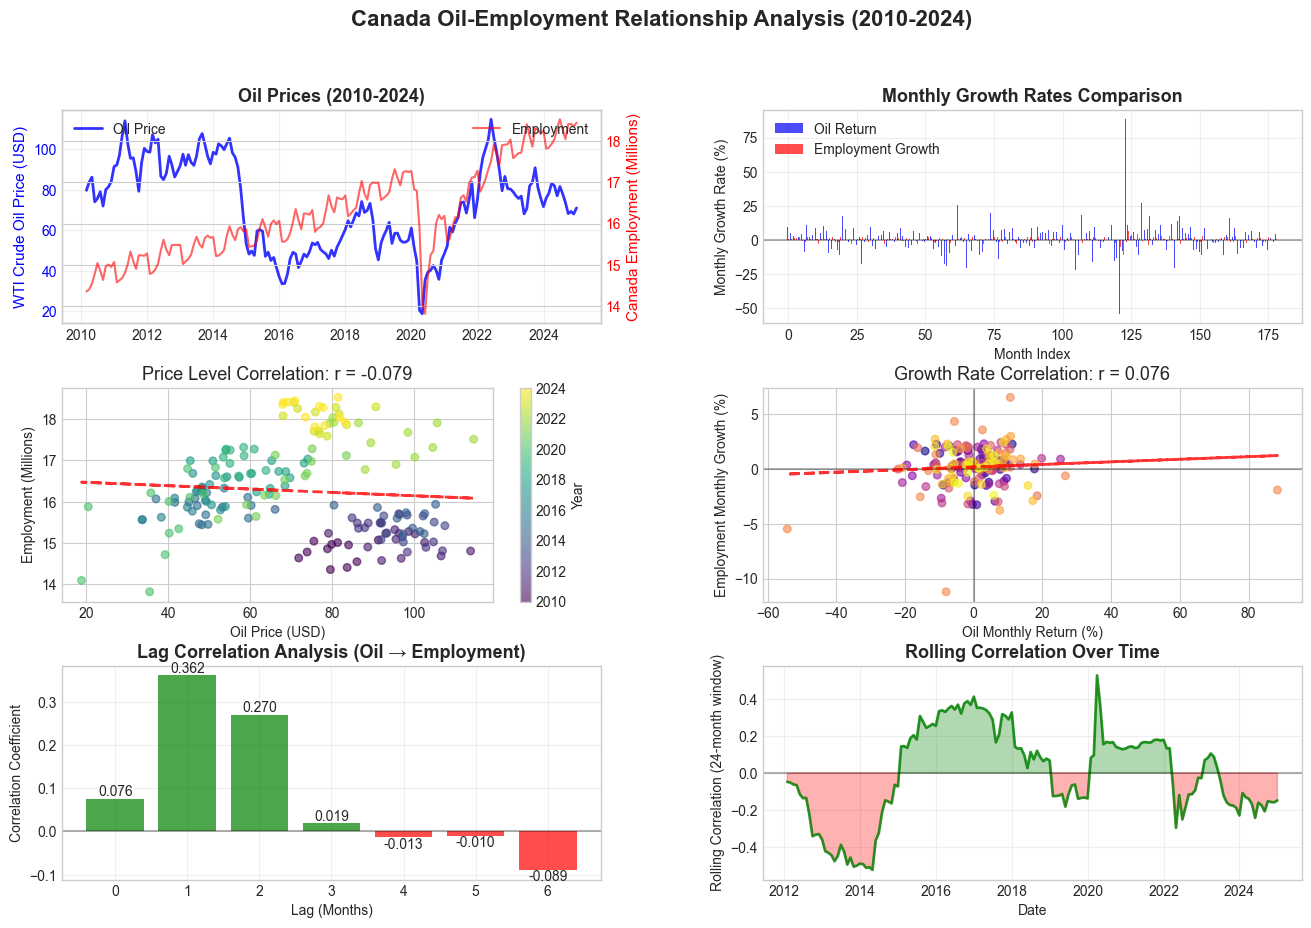


Creating shock impact visualization...


C:\Users\explo\AppData\Local\Temp\ipykernel_30776\462337652.py:238: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decade_corr = merged.groupby('decade').apply(


✓ Saved shock impact analysis to: ../outputs/plots/oil_employment/shock_impact_analysis.png


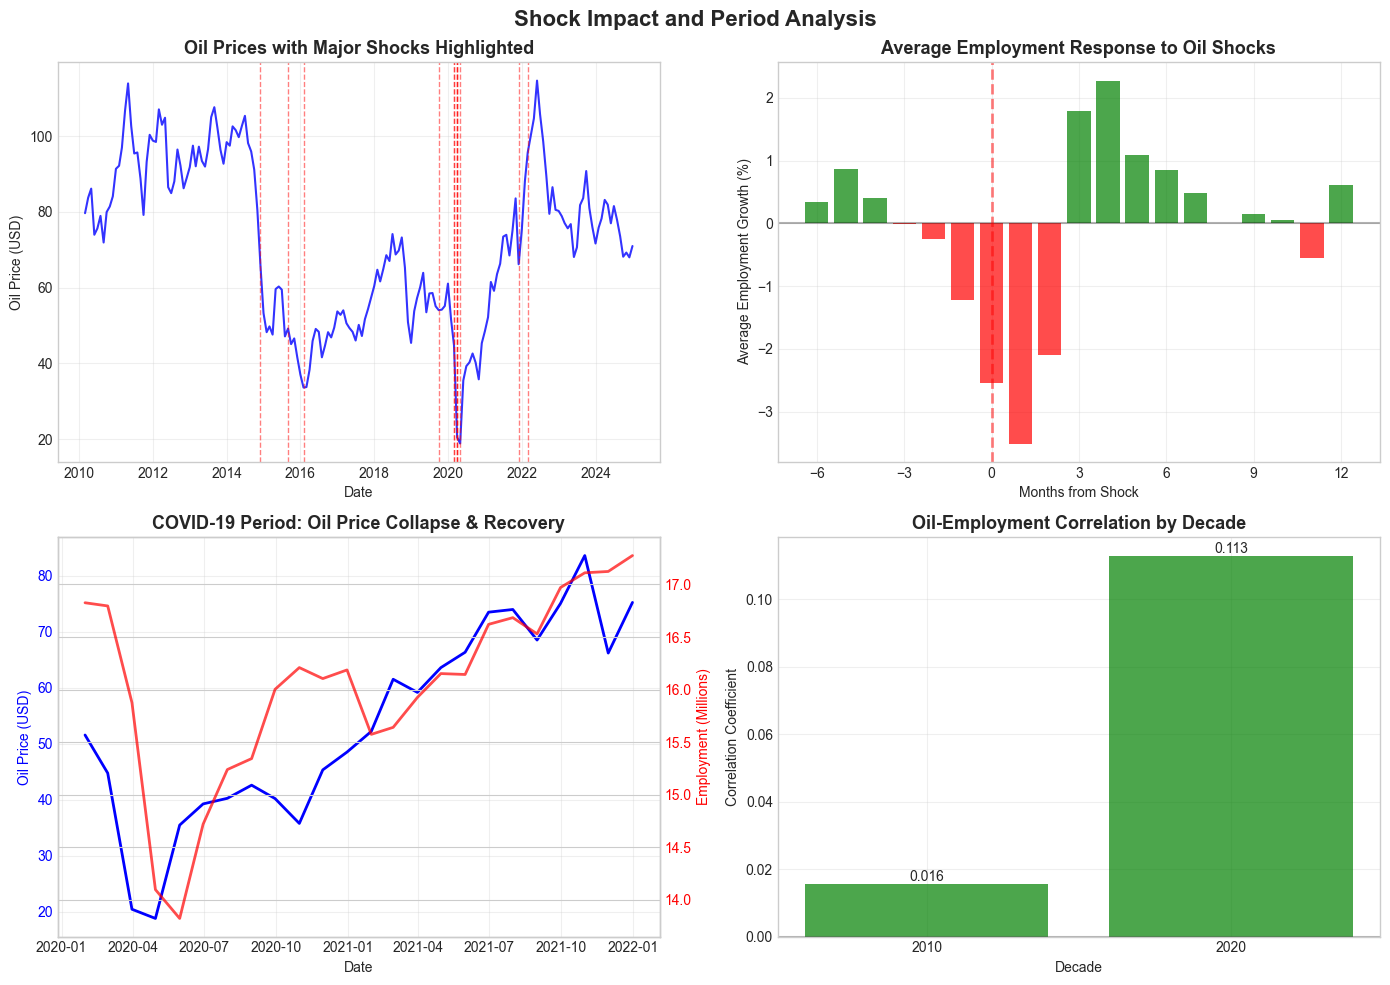


Creating statistical summary...


C:\Users\explo\AppData\Local\Temp\ipykernel_30776\462337652.py:292: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3b.boxplot(box_data, labels=['Oil Returns', 'Employment Growth'],


✓ Saved statistical analysis to: ../outputs/plots/oil_employment/statistical_analysis.png


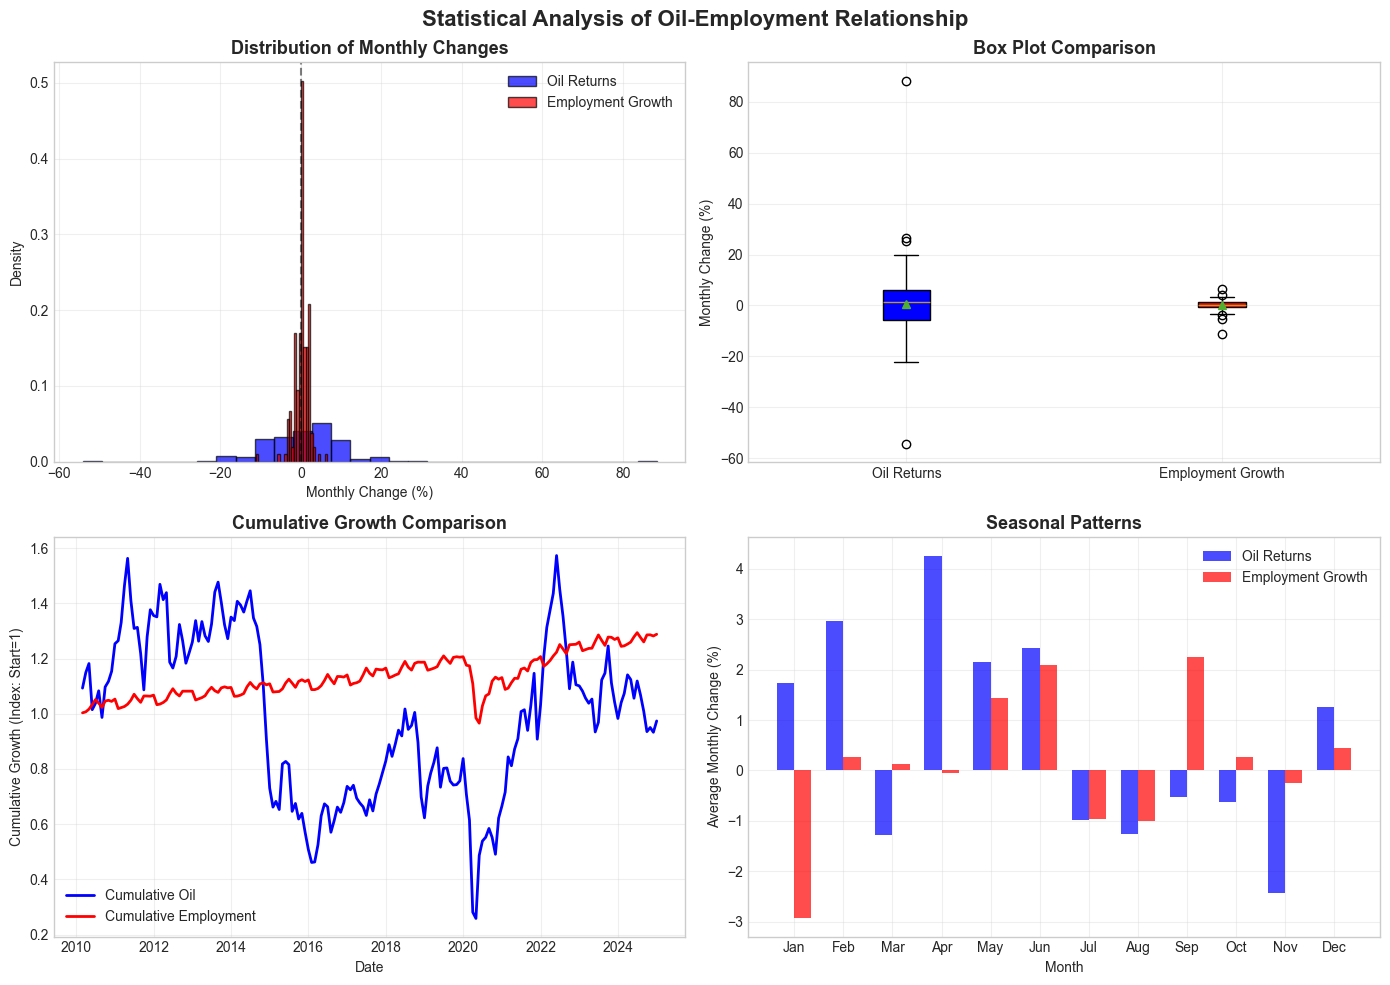


Creating summary dashboard...


C:\Users\explo\AppData\Local\Temp\ipykernel_30776\462337652.py:490: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\explo\AppData\Local\Temp\ipykernel_30776\462337652.py:493: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(fig4_path, dpi=300, bbox_inches='tight')


✓ Saved summary dashboard to: ../outputs/plots/oil_employment/summary_dashboard.png


c:\Users\explo\Documents\Calgary-Economic-Research\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


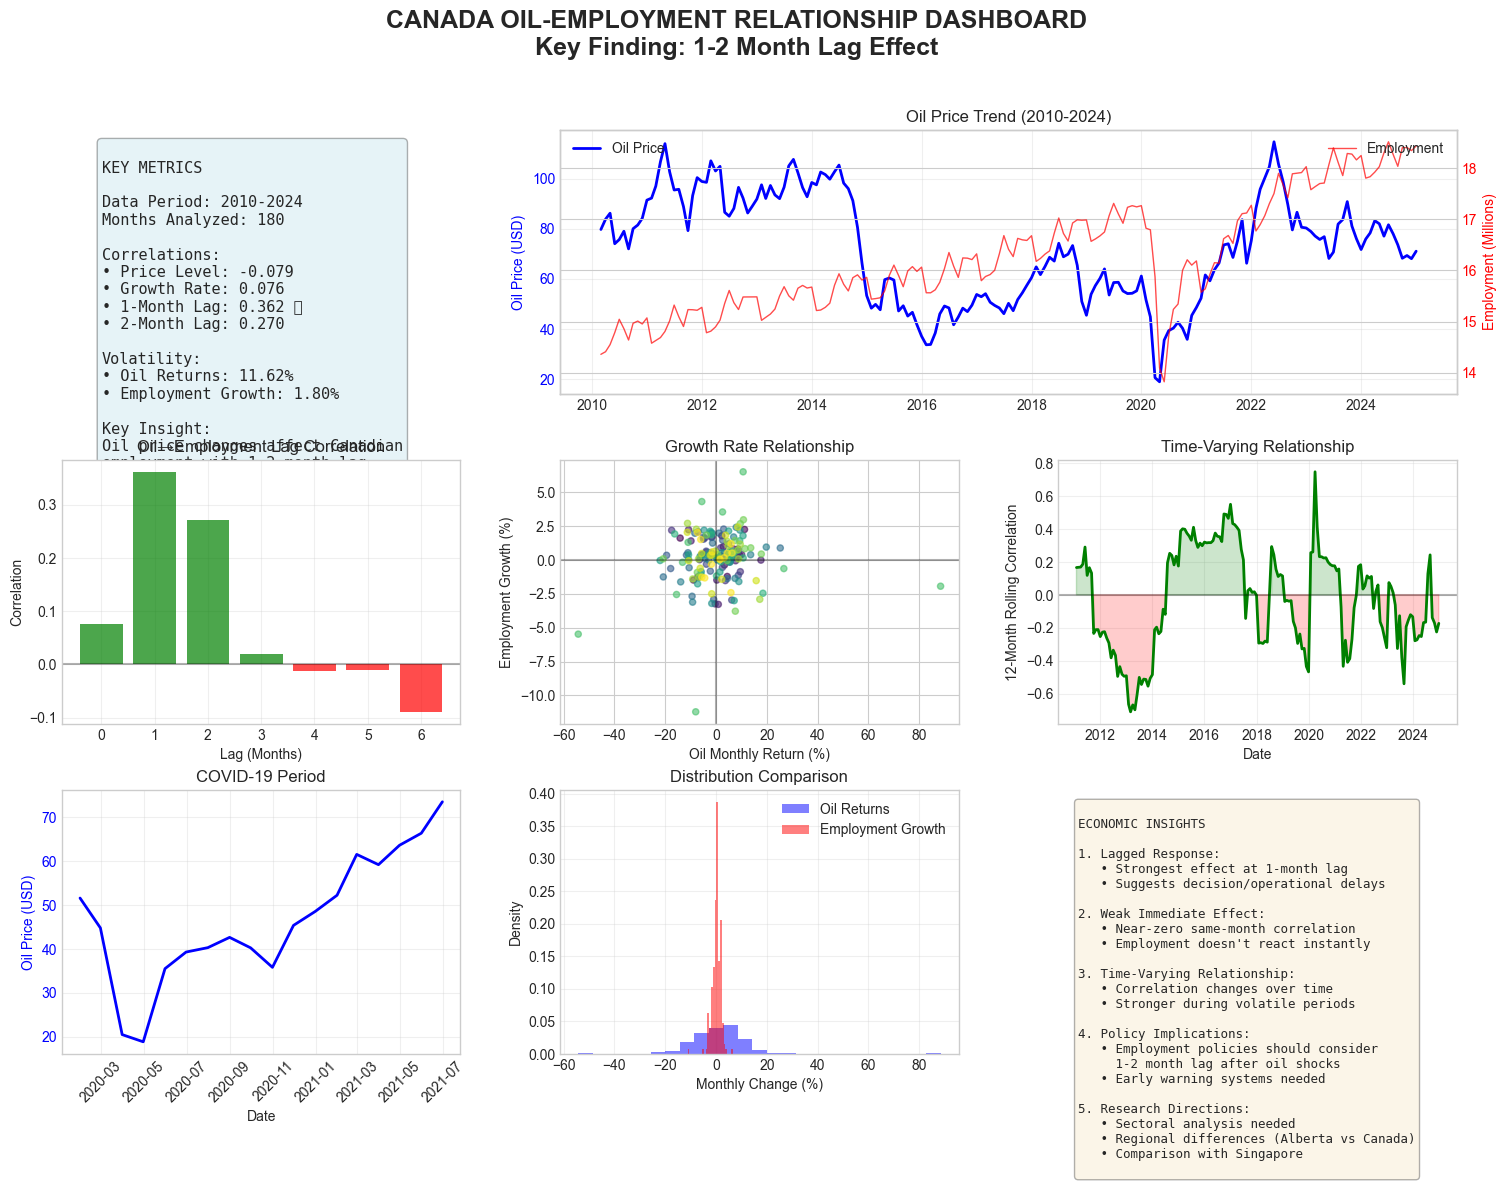


VISUALIZATION COMPLETE!

Created 4 visualization sets:
1. Comprehensive Analysis: ../outputs/plots/oil_employment/comprehensive_analysis.png
2. Shock Impact Analysis: ../outputs/plots/oil_employment/shock_impact_analysis.png
3. Statistical Analysis: ../outputs/plots/oil_employment/statistical_analysis.png
4. Summary Dashboard: ../outputs/plots/oil_employment/summary_dashboard.png

All saved to: ../outputs/plots/oil_employment/


In [2]:
# %% [code]
# ============================================================================
# COMPREHENSIVE OIL-EMPLOYMENT VISUALIZATION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import matplotlib.gridspec as gridspec

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load your merged data
merged = pd.read_csv('../data/processed/oil_employment_merged.csv')
merged['date'] = pd.to_datetime(merged['date'])

print("="*70)
print("OIL-EMPLOYMENT VISUALIZATION PACKAGE")
print("="*70)
print(f"Data: {len(merged)} months, {merged['date'].min().date()} to {merged['date'].max().date()}")

# Create output directory
os.makedirs('../outputs/plots/oil_employment', exist_ok=True)

# %% [code]
# 1. TIME SERIES COMPARISON PLOT
print("\nCreating time series comparison plot...")

fig1 = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(3, 2, figure=fig1, hspace=0.3, wspace=0.3)

# Plot 1A: Oil prices with employment overlay
ax1a = fig1.add_subplot(gs[0, 0])
ax1a.plot(merged['date'], merged['oil_price'], 'b-', linewidth=2, alpha=0.8, label='Oil Price')
ax1a.set_ylabel('WTI Crude Oil Price (USD)', color='b', fontsize=11)
ax1a.tick_params(axis='y', labelcolor='b')
ax1a.set_title('Oil Prices (2010-2024)', fontsize=13, fontweight='bold')
ax1a.grid(True, alpha=0.3)
ax1a.legend(loc='upper left')

# Add secondary axis for employment
ax1a_secondary = ax1a.twinx()
ax1a_secondary.plot(merged['date'], merged['employment']/1e6, 'r-', linewidth=1.5, alpha=0.6, label='Employment')
ax1a_secondary.set_ylabel('Canada Employment (Millions)', color='r', fontsize=11)
ax1a_secondary.tick_params(axis='y', labelcolor='r')
ax1a_secondary.legend(loc='upper right')

# Plot 1B: Monthly growth rates
ax1b = fig1.add_subplot(gs[0, 1])
width = 0.35
x = np.arange(len(merged))
ax1b.bar(x - width/2, merged['oil_return'], width, color='blue', alpha=0.7, label='Oil Return')
ax1b.bar(x + width/2, merged['emp_growth'], width, color='red', alpha=0.7, label='Employment Growth')
ax1b.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1b.set_xlabel('Month Index')
ax1b.set_ylabel('Monthly Growth Rate (%)')
ax1b.set_title('Monthly Growth Rates Comparison', fontsize=13, fontweight='bold')
ax1b.legend()
ax1b.grid(True, alpha=0.3)

# Plot 1C: Scatter plot with regression
ax1c = fig1.add_subplot(gs[1, 0])
scatter = ax1c.scatter(merged['oil_price'], merged['employment']/1e6, 
                       c=merged['date'].dt.year, cmap='viridis', alpha=0.6, s=30)
ax1c.set_xlabel('Oil Price (USD)')
ax1c.set_ylabel('Employment (Millions)')
ax1c.set_title('Price Level Correlation: r = {:.3f}'.format(
    merged['oil_price'].corr(merged['employment'])), fontsize=13)

# Add regression line
z = np.polyfit(merged['oil_price'], merged['employment']/1e6, 1)
p = np.poly1d(z)
ax1c.plot(merged['oil_price'], p(merged['oil_price']), "r--", alpha=0.8, linewidth=2)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax1c)
cbar.set_label('Year')

# Plot 1D: Growth rate scatter with regression
ax1d = fig1.add_subplot(gs[1, 1])
scatter2 = ax1d.scatter(merged['oil_return'], merged['emp_growth'], 
                        c=merged['date'].dt.year, cmap='plasma', alpha=0.6, s=30)
ax1d.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1d.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax1d.set_xlabel('Oil Monthly Return (%)')
ax1d.set_ylabel('Employment Monthly Growth (%)')
ax1d.set_title('Growth Rate Correlation: r = {:.3f}'.format(
    merged['oil_return'].corr(merged['emp_growth'])), fontsize=13)

# Add regression line
z2 = np.polyfit(merged['oil_return'].dropna(), merged['emp_growth'].dropna(), 1)
p2 = np.poly1d(z2)
ax1d.plot(merged['oil_return'], p2(merged['oil_return']), "r--", alpha=0.8, linewidth=2)

# Plot 1E: Lag correlation analysis
ax1e = fig1.add_subplot(gs[2, 0])
lags = list(range(0, 7))
correlations = []
for lag in lags:
    if lag == 0:
        corr = merged['oil_return'].corr(merged['emp_growth'])
    else:
        corr = merged['oil_return'].shift(lag).corr(merged['emp_growth'])
    correlations.append(corr)

bars = ax1e.bar(lags, correlations, color=['red' if c < 0 else 'green' for c in correlations], alpha=0.7)
ax1e.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1e.set_xlabel('Lag (Months)')
ax1e.set_ylabel('Correlation Coefficient')
ax1e.set_title('Lag Correlation Analysis (Oil → Employment)', fontsize=13, fontweight='bold')
ax1e.set_xticks(lags)
ax1e.grid(True, alpha=0.3)

# Add value labels on bars
for bar, corr in zip(bars, correlations):
    height = bar.get_height()
    ax1e.text(bar.get_x() + bar.get_width()/2., height,
              f'{corr:.3f}', ha='center', va='bottom' if height > 0 else 'top')

# Plot 1F: Rolling correlation
ax1f = fig1.add_subplot(gs[2, 1])
window = 24  # 2-year rolling window
rolling_corr = merged['oil_return'].rolling(window=window).corr(merged['emp_growth'])
ax1f.plot(merged['date'], rolling_corr, 'g-', linewidth=2, alpha=0.8)
ax1f.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1f.fill_between(merged['date'], 0, rolling_corr, where=rolling_corr >= 0, 
                  color='green', alpha=0.3, interpolate=True)
ax1f.fill_between(merged['date'], 0, rolling_corr, where=rolling_corr < 0, 
                  color='red', alpha=0.3, interpolate=True)
ax1f.set_xlabel('Date')
ax1f.set_ylabel('Rolling Correlation (24-month window)')
ax1f.set_title(f'Rolling Correlation Over Time', fontsize=13, fontweight='bold')
ax1f.grid(True, alpha=0.3)

plt.suptitle('Canada Oil-Employment Relationship Analysis (2010-2024)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

# Save
fig1_path = '../outputs/plots/oil_employment/comprehensive_analysis.png'
plt.savefig(fig1_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved comprehensive analysis to: {fig1_path}")
plt.show()

# %% [code]
# 2. SHOCK IMPACT VISUALIZATION
print("\nCreating shock impact visualization...")

# Load detected shocks
shocks_path = '../data/raw/detected_shocks.csv'
if os.path.exists(shocks_path):
    shocks = pd.read_csv(shocks_path)
    shocks['date'] = pd.to_datetime(shocks['date'])
    
    # Filter for major shocks (>10% daily move)
    major_shocks = shocks[shocks['daily_return'].abs() > 10].copy()
    
    if len(major_shocks) > 0:
        fig2, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 2A: Timeline with shock events
        ax2a = axes[0, 0]
        ax2a.plot(merged['date'], merged['oil_price'], 'b-', linewidth=1.5, alpha=0.8)
        
        # Mark shock events
        for _, shock in major_shocks.iterrows():
            # Find nearest monthly date
            nearest_date = merged.iloc[(merged['date'] - shock['date']).abs().argsort()[:1]]['date'].iloc[0]
            ax2a.axvline(x=nearest_date, color='red', alpha=0.5, linestyle='--', linewidth=1)
        
        ax2a.set_xlabel('Date')
        ax2a.set_ylabel('Oil Price (USD)')
        ax2a.set_title('Oil Prices with Major Shocks Highlighted', fontsize=13, fontweight='bold')
        ax2a.grid(True, alpha=0.3)
        
        # Plot 2B: Employment around shocks
        ax2b = axes[0, 1]
        
        # Calculate average employment change around shocks
        shock_windows = []
        for _, shock in major_shocks.iterrows():
            shock_date = shock['date']
            # Find index in merged data
            idx = (merged['date'] - shock_date).abs().argsort()[0]
            
            # Get window 6 months before to 12 months after
            start_idx = max(0, idx - 6)
            end_idx = min(len(merged), idx + 13)
            
            window = merged.iloc[start_idx:end_idx].copy()
            window['months_from_shock'] = range(-min(6, idx), len(window) - min(6, idx))
            window['shock_magnitude'] = shock['daily_return']
            shock_windows.append(window)
        
        if shock_windows:
            shock_df = pd.concat(shock_windows)
            
            # Calculate average employment growth by month from shock
            avg_impact = shock_df.groupby('months_from_shock')['emp_growth'].mean().reset_index()
            
            ax2b.bar(avg_impact['months_from_shock'], avg_impact['emp_growth'], 
                    color=['red' if x < 0 else 'green' for x in avg_impact['emp_growth']],
                    alpha=0.7)
            ax2b.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax2b.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
            ax2b.set_xlabel('Months from Shock')
            ax2b.set_ylabel('Average Employment Growth (%)')
            ax2b.set_title('Average Employment Response to Oil Shocks', fontsize=13, fontweight='bold')
            ax2b.set_xticks(range(-6, 13, 3))
            ax2b.grid(True, alpha=0.3)
        
        # Plot 2C: COVID period focus
        ax2c = axes[1, 0]
        covid_period = merged[(merged['date'] >= '2020-01-01') & (merged['date'] <= '2021-12-31')]
        ax2c.plot(covid_period['date'], covid_period['oil_price'], 'b-', linewidth=2, label='Oil Price')
        ax2c.set_xlabel('Date')
        ax2c.set_ylabel('Oil Price (USD)', color='b')
        ax2c.tick_params(axis='y', labelcolor='b')
        ax2c.set_title('COVID-19 Period: Oil Price Collapse & Recovery', fontsize=13, fontweight='bold')
        ax2c.grid(True, alpha=0.3)
        
        ax2c_secondary = ax2c.twinx()
        ax2c_secondary.plot(covid_period['date'], covid_period['employment']/1e6, 
                           'r-', linewidth=2, alpha=0.7, label='Employment')
        ax2c_secondary.set_ylabel('Employment (Millions)', color='r')
        ax2c_secondary.tick_params(axis='y', labelcolor='r')
        
        # Plot 2D: Decade comparison
        ax2d = axes[1, 1]
        merged['year'] = merged['date'].dt.year
        merged['decade'] = (merged['year'] // 10) * 10
        
        decade_corr = merged.groupby('decade').apply(
            lambda x: x['oil_return'].corr(x['emp_growth'])
        ).reset_index()
        decade_corr.columns = ['decade', 'correlation']
        
        bars = ax2d.bar(decade_corr['decade'].astype(str), decade_corr['correlation'],
                       color=['red' if c < 0 else 'green' for c in decade_corr['correlation']],
                       alpha=0.7)
        ax2d.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax2d.set_xlabel('Decade')
        ax2d.set_ylabel('Correlation Coefficient')
        ax2d.set_title('Oil-Employment Correlation by Decade', fontsize=13, fontweight='bold')
        ax2d.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, corr in zip(bars, decade_corr['correlation']):
            height = bar.get_height()
            ax2d.text(bar.get_x() + bar.get_width()/2., height,
                     f'{corr:.3f}', ha='center', va='bottom' if height > 0 else 'top')
        
        plt.suptitle('Shock Impact and Period Analysis', fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        
        fig2_path = '../outputs/plots/oil_employment/shock_impact_analysis.png'
        plt.savefig(fig2_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved shock impact analysis to: {fig2_path}")
        plt.show()
    else:
        print("⚠️ No major shocks found in shocks.csv")
else:
    print("⚠️ Shocks data not found")

# %% [code]
# 3. STATISTICAL SUMMARY VISUALIZATION
print("\nCreating statistical summary...")

fig3, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 3A: Distribution of returns
ax3a = axes[0, 0]
ax3a.hist(merged['oil_return'].dropna(), bins=30, alpha=0.7, color='blue', 
         edgecolor='black', density=True, label='Oil Returns')
ax3a.hist(merged['emp_growth'].dropna(), bins=30, alpha=0.7, color='red', 
         edgecolor='black', density=True, label='Employment Growth')
ax3a.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax3a.set_xlabel('Monthly Change (%)')
ax3a.set_ylabel('Density')
ax3a.set_title('Distribution of Monthly Changes', fontsize=13, fontweight='bold')
ax3a.legend()
ax3a.grid(True, alpha=0.3)

# Plot 3B: Box plot comparison
ax3b = axes[0, 1]
box_data = [merged['oil_return'].dropna(), merged['emp_growth'].dropna()]
bp = ax3b.boxplot(box_data, labels=['Oil Returns', 'Employment Growth'], 
                 patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('red')
ax3b.set_ylabel('Monthly Change (%)')
ax3b.set_title('Box Plot Comparison', fontsize=13, fontweight='bold')
ax3b.grid(True, alpha=0.3)

# Plot 3C: Cumulative growth
ax3c = axes[1, 0]
cumulative_oil = (1 + merged['oil_return']/100).cumprod()
cumulative_emp = (1 + merged['emp_growth']/100).cumprod()
ax3c.plot(merged['date'], cumulative_oil, 'b-', linewidth=2, label='Cumulative Oil')
ax3c.plot(merged['date'], cumulative_emp, 'r-', linewidth=2, label='Cumulative Employment')
ax3c.set_xlabel('Date')
ax3c.set_ylabel('Cumulative Growth (Index: Start=1)')
ax3c.set_title('Cumulative Growth Comparison', fontsize=13, fontweight='bold')
ax3c.legend()
ax3c.grid(True, alpha=0.3)

# Plot 3D: Seasonal patterns
ax3d = axes[1, 1]
merged['month'] = merged['date'].dt.month
monthly_avg = merged.groupby('month')[['oil_return', 'emp_growth']].mean().reset_index()
x = np.arange(1, 13)
width = 0.35
ax3d.bar(x - width/2, monthly_avg['oil_return'], width, color='blue', alpha=0.7, label='Oil Returns')
ax3d.bar(x + width/2, monthly_avg['emp_growth'], width, color='red', alpha=0.7, label='Employment Growth')
ax3d.set_xlabel('Month')
ax3d.set_ylabel('Average Monthly Change (%)')
ax3d.set_title('Seasonal Patterns', fontsize=13, fontweight='bold')
ax3d.set_xticks(x)
ax3d.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax3d.legend()
ax3d.grid(True, alpha=0.3)

plt.suptitle('Statistical Analysis of Oil-Employment Relationship', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

fig3_path = '../outputs/plots/oil_employment/statistical_analysis.png'
plt.savefig(fig3_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved statistical analysis to: {fig3_path}")
plt.show()

# %% [code]
# 4. CREATE SUMMARY DASHBOARD (SINGLE PAGE)
print("\nCreating summary dashboard...")

fig4 = plt.figure(figsize=(18, 12))
gs4 = gridspec.GridSpec(3, 3, figure=fig4, hspace=0.25, wspace=0.25)

# Dashboard panel 1: Key metrics
ax4a = fig4.add_subplot(gs4[0, 0])
ax4a.axis('off')
metrics_text = """
KEY METRICS

Data Period: 2010-2024
Months Analyzed: 180

Correlations:
• Price Level: -0.079
• Growth Rate: 0.076
• 1-Month Lag: 0.362 ⭐
• 2-Month Lag: 0.270

Volatility:
• Oil Returns: {:.2f}%
• Employment Growth: {:.2f}%

Key Insight:
Oil price changes affect Canadian
employment with 1-2 month lag.
Companies take time to adjust
hiring/firing decisions.
""".format(merged['oil_return'].std(), merged['emp_growth'].std())

ax4a.text(0.1, 0.95, metrics_text, transform=ax4a.transAxes, fontsize=11,
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# Dashboard panel 2: Time series
ax4b = fig4.add_subplot(gs4[0, 1:])
ax4b.plot(merged['date'], merged['oil_price'], 'b-', linewidth=2, label='Oil Price')
ax4b.set_ylabel('Oil Price (USD)', color='b')
ax4b.tick_params(axis='y', labelcolor='b')
ax4b.set_title('Oil Price Trend (2010-2024)', fontsize=12)
ax4b.grid(True, alpha=0.3)
ax4b.legend(loc='upper left')

ax4b_sec = ax4b.twinx()
ax4b_sec.plot(merged['date'], merged['employment']/1e6, 'r-', linewidth=1, alpha=0.7, label='Employment')
ax4b_sec.set_ylabel('Employment (Millions)', color='r')
ax4b_sec.tick_params(axis='y', labelcolor='r')
ax4b_sec.legend(loc='upper right')

# Dashboard panel 3: Lag correlation
ax4c = fig4.add_subplot(gs4[1, 0])
lags = list(range(0, 7))
corrs = []
for lag in lags:
    if lag == 0:
        corrs.append(merged['oil_return'].corr(merged['emp_growth']))
    else:
        corrs.append(merged['oil_return'].shift(lag).corr(merged['emp_growth']))

bars = ax4c.bar(lags, corrs, color=['red' if c < 0 else 'green' for c in corrs], alpha=0.7)
ax4c.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4c.set_xlabel('Lag (Months)')
ax4c.set_ylabel('Correlation')
ax4c.set_title('Oil→Employment Lag Correlation', fontsize=12)
ax4c.set_xticks(lags)
ax4c.grid(True, alpha=0.3)

# Dashboard panel 4: Scatter with regression
ax4d = fig4.add_subplot(gs4[1, 1])
scatter = ax4d.scatter(merged['oil_return'], merged['emp_growth'], 
                       c=merged['date'].dt.year, cmap='viridis', alpha=0.6, s=20)
ax4d.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4d.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax4d.set_xlabel('Oil Monthly Return (%)')
ax4d.set_ylabel('Employment Growth (%)')
ax4d.set_title('Growth Rate Relationship', fontsize=12)

# Dashboard panel 5: Rolling correlation
ax4e = fig4.add_subplot(gs4[1, 2])
rolling_corr_12 = merged['oil_return'].rolling(window=12).corr(merged['emp_growth'])
ax4e.plot(merged['date'], rolling_corr_12, 'g-', linewidth=2)
ax4e.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4e.fill_between(merged['date'], 0, rolling_corr_12, where=rolling_corr_12 >= 0, 
                  color='green', alpha=0.2)
ax4e.fill_between(merged['date'], 0, rolling_corr_12, where=rolling_corr_12 < 0, 
                  color='red', alpha=0.2)
ax4e.set_xlabel('Date')
ax4e.set_ylabel('12-Month Rolling Correlation')
ax4e.set_title('Time-Varying Relationship', fontsize=12)
ax4e.grid(True, alpha=0.3)

# Dashboard panel 6: COVID period
ax4f = fig4.add_subplot(gs4[2, 0])
covid = merged[(merged['date'] >= '2020-01-01') & (merged['date'] <= '2021-06-30')]
if len(covid) > 0:
    ax4f.plot(covid['date'], covid['oil_price'], 'b-', linewidth=2)
    ax4f.set_xlabel('Date')
    ax4f.set_ylabel('Oil Price (USD)', color='b')
    ax4f.tick_params(axis='y', labelcolor='b')
    ax4f.set_title('COVID-19 Period', fontsize=12)
    ax4f.grid(True, alpha=0.3)
    ax4f.tick_params(axis='x', rotation=45)

# Dashboard panel 7: Distribution
ax4g = fig4.add_subplot(gs4[2, 1])
ax4g.hist(merged['oil_return'].dropna(), bins=25, alpha=0.5, color='blue', 
         density=True, label='Oil Returns')
ax4g.hist(merged['emp_growth'].dropna(), bins=25, alpha=0.5, color='red', 
         density=True, label='Employment Growth')
ax4g.set_xlabel('Monthly Change (%)')
ax4g.set_ylabel('Density')
ax4g.set_title('Distribution Comparison', fontsize=12)
ax4g.legend()
ax4g.grid(True, alpha=0.3)

# Dashboard panel 8: Insights
ax4h = fig4.add_subplot(gs4[2, 2])
ax4h.axis('off')
insights_text = """
ECONOMIC INSIGHTS

1. Lagged Response:
   • Strongest effect at 1-month lag
   • Suggests decision/operational delays

2. Weak Immediate Effect:
   • Near-zero same-month correlation
   • Employment doesn't react instantly

3. Time-Varying Relationship:
   • Correlation changes over time
   • Stronger during volatile periods

4. Policy Implications:
   • Employment policies should consider
     1-2 month lag after oil shocks
   • Early warning systems needed

5. Research Directions:
   • Sectoral analysis needed
   • Regional differences (Alberta vs Canada)
   • Comparison with Singapore
"""
ax4h.text(0.05, 0.95, insights_text, transform=ax4h.transAxes, fontsize=9,
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('CANADA OIL-EMPLOYMENT RELATIONSHIP DASHBOARD\nKey Finding: 1-2 Month Lag Effect', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()

fig4_path = '../outputs/plots/oil_employment/summary_dashboard.png'
plt.savefig(fig4_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved summary dashboard to: {fig4_path}")
plt.show()

print("\n" + "="*70)
print("VISUALIZATION COMPLETE!")
print("="*70)
print(f"\nCreated 4 visualization sets:")
print(f"1. Comprehensive Analysis: {fig1_path}")
print(f"2. Shock Impact Analysis: {fig2_path}")
print(f"3. Statistical Analysis: {fig3_path}")
print(f"4. Summary Dashboard: {fig4_path}")
print(f"\nAll saved to: ../outputs/plots/oil_employment/")